In [1]:
%matplotlib inline
from pylab import *
# import cv2
import rasterio as rio

rcParams['figure.figsize'] = 10, 10

# from dataset import load_image

import torch
from torch import nn
from torch.nn import functional as F
import torch
from torchvision import models
import torchvision
from torchvision.transforms import ToTensor, Normalize, Compose
#from utils import variable
# from generate_masks import get_model
#from unet_models import unet11_MS

font = {'family' : 'normal',
        'weight' : 'medium',
        'size'   : 14}

matplotlib.rc('font', **font)

# import the helper functions
sys.path.append('../')
from test_unet_helpers import *

import glob
import os,sys
from matplotlib import pyplot as plt
import numpy as np
from scipy import misc
import fiona
from shapely.geometry import shape
import shapely
from rasterio.mask import mask
from pyproj import Proj, transform

In [21]:
# specify scene id for DG data
dg_scene_id = '1030010057062200'

# specify image for 2.0 meter analysis
gt_image_2 = '../rasters/union_impervious_raster_2_0_0_wgs84.tif' # aws
gt_image_2 = '../../../smart_cities/Denver_Sample_Sites/rasters/union_impervious_raster_2_0_0_wgs84.tif' # desktop

# specify images for 0.5 meter analysis
gt_image_05 = '../../../smart_cities/Denver_Sample_Sites/rasters/union_impervious_raster_0_5_wgs84_SnapR.tif' # aws

# specify the shapefile
shpfile = '../union/union.shp' # aws
shpfile = '../../../smart_cities/Denver_Sample_Sites/union/union.shp' #desktop

# specify the DG result files
dg_LULC = '../../../smart_cities/gbdx_outputs/LULC/055530875010_01_assembly_EXT_NEL_LULC.tif'
dg_BUE = '../../../smart_cities/gbdx_outputs/BUextent/055530875010_01_assembly_EXT_BEX_PANTEX10.tif'
dg_unet = '../../../smart_cities/impervious_surface_analysis/for_paper/model_improvements/denver_2016_psacomp_1030010057062200_BGRN1_512x512.tif'

rows = []

with fiona.open(shpfile) as shp:
    crs = shp.crs
    shp_bounds = shp.bounds
    
    features = [feature["geometry"] for feature in shp]

In [6]:
from gbdxtools import Interface, CatalogImage

# connect to gbdx
gbdx = Interface()

# get the dask array for the 8 band MS image
img_2m = CatalogImage(dg_scene_id, band_type='MS', bbox=shp_bounds, acomp=True)
img_2m_toa = CatalogImage(dg_scene_id, band_type='MS', bbox=shp_bounds, acomp=False)
rows, cols = img_2m.shape[1:]

# get the dask array for the Pansharpened, 4 band image
image_05m = CatalogImage(dg_scene_id, bbox=shp_bounds, acomp=True, pansharpen=True)
rowsP, colsP = image_05m.shape[1:]
pan_factorR = np.floor(rowsP/rows)
pan_factorC = np.floor(colsP/cols)

C:\software\anaconda3\envs\eapy_gbdx\lib\site-packages\gbdxtools\images\meta.py:21: UserWarning: ShareDict has been deprecated in favor of HighLevelGraph and will be removed in future versions
  from dask import sharedict, optimization


In [8]:
## load the data
coords = np.loadtxt(r'D:\projects\RD\debug_IS_segmentation\kmeans3_split\image_coords_256x256.txt')
coords_pan = np.loadtxt(r'D:\projects\RD\debug_IS_segmentation\kmeans3_split\image_coords_1064x1064.txt')

# image_transforms
gt_transform = Compose([
    ToTensor()
    ])

dg_transform = Compose([])

# mode = 'PS'
mode = 'MS'
side=256
if mode == 'PS':
    gt_im = gt_image_05
    dg_im = image_05m/10000
    
    use_coords = coords_pan
    train_coords = coords_pan[coords_pan[:,2] == 0][:,:2]
    val_coords = coords_pan[coords_pan[:,2] == 1][:,:2]
    test_coords = coords_pan[coords_pan[:,2] == 2][:,:2]
    
    winsize = 512 # something off about above
    
    img_transform=dg_transform
    
else:
    gt_im = gt_image_2
    dg_im = img_2m/10000
    
    use_coords = coords
    train_coords = coords[coords[:,2] == 0][:,:2]
    val_coords = coords[coords[:,2] == 1][:,:2]
    test_coords = coords[coords[:,2] == 2][:,:2]
    
    winsize=side
    
    img_transform=gt_transform # for use with dividing image by 10000
    
    

dg_dataset_train = DigitalGlobeSamplerTensor(dg_im, train_coords, transform=dg_transform, window_size=winsize, comb='all') # will return RGB by default
dg_dataset_val = DigitalGlobeSamplerTensor(dg_im, val_coords, transform=dg_transform, window_size=winsize, comb='all')
dg_dataset_test = DigitalGlobeSamplerTensor(dg_im, test_coords, transform=dg_transform, window_size=winsize, comb='all')

gt_dataset_train = gtDatasetSampler2(gt_im, train_coords, transform=gt_transform, window_size=winsize) 
gt_dataset_val = gtDatasetSampler2(gt_im, val_coords, transform=gt_transform, window_size=winsize)
gt_dataset_test = gtDatasetSampler2(gt_im, test_coords, transform=gt_transform, window_size=winsize)

In [24]:
class BUEDatasetSampler2(Dataset):
    """DG Dataset"""
    def __init__(self, buefile, coord_pair, bnds, window_size=64, transform=None):
        """ 
        Args:
            image_dir(string): the folder containing the DG images
            transform (callable, optional): Optional transform to  be applies
        """
        self.image_file = buefile
        self.transform = transform
        self.coords = coord_pair
        self.window_size = window_size
        self.boundary = bnds
        
    
    def __getitem__(self, idx):
        
        with rasterio.open(self.image_file, 'r') as src:
            temp, _ = mask(src, self.boundary, crop=True)
            temp = temp.astype('float')
        
        # get the window
        r,c = self.coords[idx]
        print(r,c)
        r_start = int(r - self.window_size/2)
        r_end = int(r_start + self.window_size)
        c_start = int(c - self.window_size/2)
        c_end = int(c_start + self.window_size)
        
        # extract the window
        img_arr = temp[0,r_start:r_end, c_start:c_end]
        img_arr = np.expand_dims(img_arr, axis=0)

        # set no data to 0
        img_arr[img_arr == 3] = 0
        
        # convert to tensor
        img_arr = torch.from_numpy(img_arr.astype('float32')).float()
        
        return img_arr
    
    def __len__(self):
        return len(self.coords)
    
class LULCDatasetSampler2(Dataset):
    """DG Dataset"""
    def __init__(self, lulcfile, coord_pair, bnds, window_size=64, transform=None):
        """ 
        Args:
            image_dir(string): the folder containing the DG images
            transform (callable, optional): Optional transform to  be applies
        """
        self.image_file = lulcfile
        self.transform = transform
        self.coords = coord_pair
        self.window_size = window_size
        self.boundary = bnds
        
    
    def __getitem__(self, idx):
        
        with rasterio.open(self.image_file, 'r') as src:
            temp, _ = mask(src, self.boundary, crop=True)
            temp = temp.astype('float')
        
        # get the window
        r,c = self.coords[idx]
        print(r,c)
        r_start = int(r - self.window_size/2)
        r_end = int(r_start + self.window_size)
        c_start = int(c - self.window_size/2)
        c_end = int(c_start + self.window_size)
        
        # extract the window
        img_arr = temp[:,r_start:r_end, c_start:c_end]
        #img_arr = np.expand_dims(img_arr, axis=0)

        # set no data to 0
        img_arr[img_arr == 3] = 0
        
        # convert to tensor
        img_arr = torch.from_numpy(img_arr.astype('float32')).float()
        
        return img_arr
    
    def __len__(self):
        return len(self.coords)



lulc_dataset_val = LULCDatasetSampler2(dg_LULC, val_coords, features, transform=gt_transform, window_size=winsize)
bue_dataset_val = BUEDatasetSampler2(dg_BUE, val_coords, features, transform=gt_transform, window_size=winsize)
unet_dataset_val = gtDatasetSampler2(dg_unet, val_coords, transform=gt_transform, window_size=winsize)

gt_dataset_train = gtDatasetSampler2(gt_im, train_coords, transform=gt_transform, window_size=winsize) 
gt_dataset_val = gtDatasetSampler2(gt_im, val_coords, transform=gt_transform, window_size=winsize)
gt_dataset_test = gtDatasetSampler2(gt_im, test_coords, transform=gt_transform, window_size=winsize)

1404.0 595.0
1404.0 595.0
1404.0 595.0


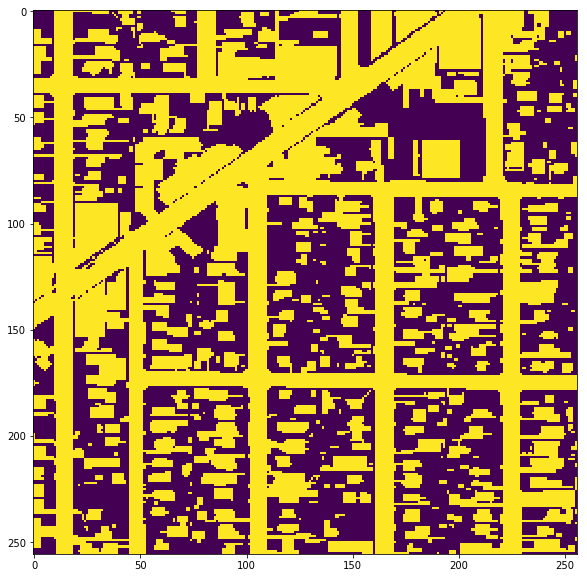

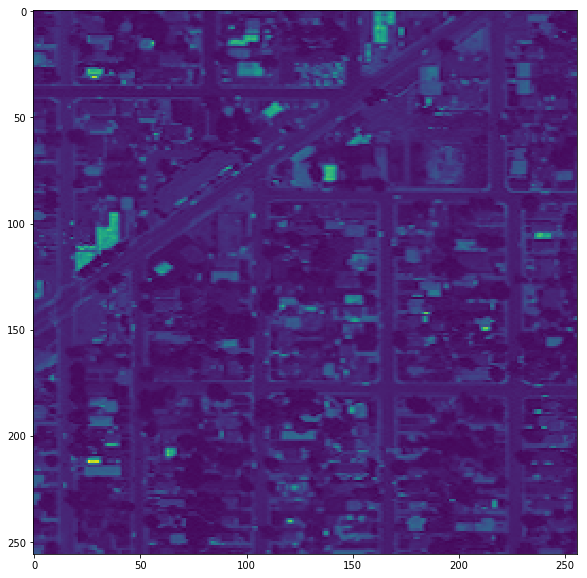

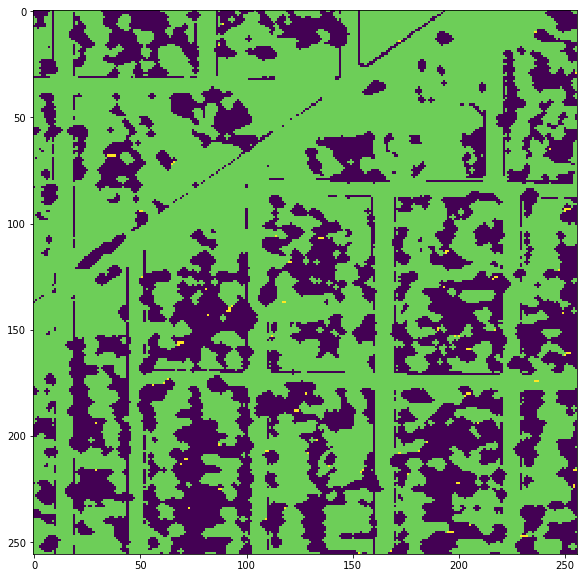

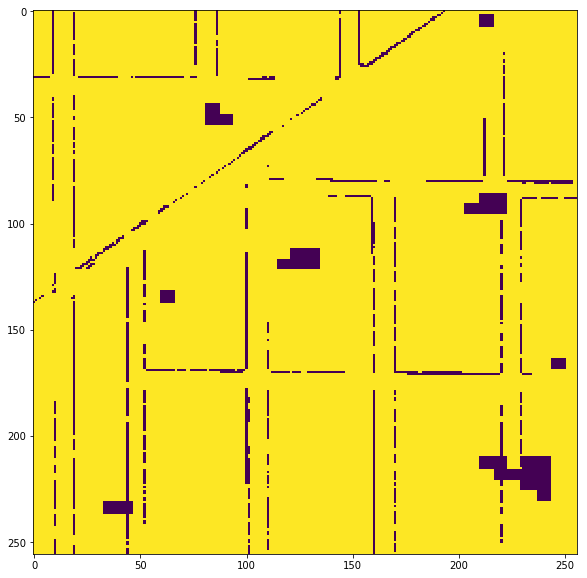

In [25]:
ind = 154#, print(coords[ind])

plt.figure(figsize=(10,10))
plt.imshow(gt_dataset_val[ind][0]);

plt.figure(figsize=(10,10))
plt.imshow(dg_dataset_val[ind][0,:,:]);

plt.figure(figsize=(10,10))
plt.imshow(lulc_dataset_val[ind][0]);

plt.figure(figsize=(10,10))
plt.imshow(bue_dataset_val[ind][0]);



In [26]:
# some functions to write the data
def gt_write(outfilename, basic_image):
    
    kwargs = {
        "crs": rio.crs.CRS({"init": "epsg:4326"}),
        "transform": rio.Affine.identity(),
        "count": 1,
        "dtype": rio.uint8,
        "driver": "GTiff",
        "width": basic_image.shape[2],
        "height": basic_image.shape[1],
        "nodata": None,
    }
    with rio.open(outfilename, "w", **kwargs) as out:
        out.write(basic_image)
    
    return outfilename

def dg_write(outfilename, basic_image):
    
    kwargs = {
        "crs": rio.crs.CRS({"init": "epsg:4326"}),
        "transform": rio.Affine.identity(),
        "count": 8,
        "dtype": rio.float32,
        "driver": "GTiff",
        "width": basic_image.shape[2],
        "height": basic_image.shape[1],
        "nodata": None,
    }
    with rio.open(outfilename, "w", **kwargs) as out:
        out.write(basic_image)
    
    return outfilename

def lulc_write(outfilename, basic_image):
    
    kwargs = {
        "crs": rio.crs.CRS({"init": "epsg:4326"}),
        "transform": rio.Affine.identity(),
        "count": 3,
        "dtype": rio.uint8,
        "driver": "GTiff",
        "width": basic_image.shape[2],
        "height": basic_image.shape[1],
        "nodata": None,
    }
    with rio.open(outfilename, "w", **kwargs) as out:
        out.write(basic_image)
    
    return outfilename

def bue_write(outfilename, basic_image):
    
    kwargs = {
        "crs": rio.crs.CRS({"init": "epsg:4326"}),
        "transform": rio.Affine.identity(),
        "count": 1,
        "dtype": rio.uint8,
        "driver": "GTiff",
        "width": basic_image.shape[2],
        "height": basic_image.shape[1],
        "nodata": None,
    }
    with rio.open(outfilename, "w", **kwargs) as out:
        out.write(basic_image)
    
    return outfilename

def unet_write(outfilename, basic_image):
    
    kwargs = {
        "crs": rio.crs.CRS({"init": "epsg:4326"}),
        "transform": rio.Affine.identity(),
        "count": 1,
        "dtype": rio.float32,
        "driver": "GTiff",
        "width": basic_image.shape[2],
        "height": basic_image.shape[1],
        "nodata": None,
    }
    with rio.open(outfilename, "w", **kwargs) as out:
        out.write(basic_image)
    
    return outfilename

In [12]:
# iterate over the data
cnt=0
for chipset, typ in zip( ((gt_dataset_train, dg_dataset_train), (gt_dataset_val, dg_dataset_val), (gt_dataset_test, dg_dataset_test)), ('train', 'val', 'test') ):
    
    # construct the base folder
    if mode == 'PS':
        base_folder = '../../debug_IS_segmentation/kmeans3_split/tilesPS_d10000_{}x{}/{}'.format(winsize,winsize,typ) #desktop
    else:
        base_folder = '../../debug_IS_segmentation/kmeans3_split/tiles_d10000_{}x{}/{}'.format(winsize,winsize,typ) #desktop
    
    if not os.path.exists(base_folder):
        print('creating', base_folder)
        os.makedirs(base_folder)
        
    # separate the chipsets
    gt_set, dg_set = chipset
    
    print('chipping {} set'.format(typ))
    # iterate over the chipsets
    #for gt_tensor, dg_tensor in zip(gt_set, dg_set):
    for i in range(len(gt_set)):
        
        try:
            gt_tensor=gt_set[i]
            dg_tensor=dg_set[i]
            
            # write out the ground truth rasters
            gt_name = 'gt_is_{0:05d}.tif'.format(cnt)
            gt_fi = os.path.join(base_folder, gt_name)
            gt_write(gt_fi, gt_tensor.numpy().astype('uint8'))

            # write out the dg rasters
            dg_name = 'dg_is_{0:05d}.tif'.format(cnt)
            dg_fi = os.path.join(base_folder, dg_name)
            dg_write(dg_fi, dg_tensor.numpy().astype('float32'))
        
            cnt+=1
            
        except:
            print('skipping index {}'.format(i))
            cnt+=1
            continue
    
        
        
        
        
        

creating ../../debug_IS_segmentation/kmeans3_split/tiles_d10000_256x256/train
chipping train set
creating ../../debug_IS_segmentation/kmeans3_split/tiles_d10000_256x256/val
chipping val set
creating ../../debug_IS_segmentation/kmeans3_split/tiles_d10000_256x256/test
chipping test set


In [27]:
# iterate over the data (DG outputs only)
cnt=500 #val started at 500
typ = 'val'
chipset = (lulc_dataset_val, bue_dataset_val, unet_dataset_val)


# construct the base folder
if mode == 'PS':
    base_folder = '../../debug_IS_segmentation/kmeans3_split/dg_products/tilesPS_d10000_{}x{}/{}'.format(winsize,winsize,typ) #desktop
else:
    base_folder = '../../debug_IS_segmentation/kmeans3_split/dg_products/tiles_d10000_{}x{}/{}'.format(winsize,winsize,typ) #desktop

if not os.path.exists(base_folder):
    print('creating', base_folder)
    os.makedirs(base_folder)

# separate the chipsets
lulc_set, bue_set, unet_set = chipset

print('chipping {} set'.format(typ))
# iterate over the chipsets
#for gt_tensor, dg_tensor in zip(gt_set, dg_set):
for i in range(len(unet_set)):

    try:
        lulc_tensor = lulc_set[i]
        bue_tensor = bue_set[i]
        unet_tensor = unet_set[i]

        # write out the lulc rasters
        lulc_name = 'lulc_is_{0:05d}.tif'.format(cnt)
        lulc_fi = os.path.join(base_folder, lulc_name)
        lulc_write(lulc_fi, lulc_tensor.numpy().astype('uint8'))

        # write out the bue rasters
        bue_name = 'bue_is_{0:05d}.tif'.format(cnt)
        bue_fi = os.path.join(base_folder, bue_name)
        bue_write(bue_fi, bue_tensor.numpy().astype('uint8'))
        
        # write out the unet rasters
        unet_name = 'unet_is_{0:05d}.tif'.format(cnt)
        unet_fi = os.path.join(base_folder, unet_name)
        unet_write(unet_fi, unet_tensor.numpy().astype('float32'))
        
        cnt+=1

    except Exception as e:
        print(e)
        print('skipping index {}'.format(i))
        cnt+=1
        continue


        
        
        

chipping val set
1485.0 544.0
1485.0 544.0
1485.0 544.0


C:\software\anaconda3\envs\eapy_gbdx\lib\site-packages\rasterio\__init__.py:225: NotGeoreferencedWarning: The given matrix is equal to Affine.identity or its flipped counterpart. GDAL may ignore this matrix and save no geotransform without raising an error. This behavior is somewhat driver-specific.
  **kwargs)


1423.0 1343.0
1423.0 1343.0
1423.0 1343.0
1308.0 993.0
1308.0 993.0
1308.0 993.0
1398.0 1429.0
1398.0 1429.0
1398.0 1429.0
1531.0 1156.0
1531.0 1156.0
1531.0 1156.0
1414.0 672.0
1414.0 672.0
1414.0 672.0
1273.0 914.0
1273.0 914.0
1273.0 914.0
1375.0 760.0
1375.0 760.0
1375.0 760.0
1594.0 681.0
1594.0 681.0
1594.0 681.0
1299.0 532.0
1299.0 532.0
1299.0 532.0
1367.0 1225.0
1367.0 1225.0
1367.0 1225.0
1459.0 1060.0
1459.0 1060.0
1459.0 1060.0
1214.0 1435.0
1214.0 1435.0
1214.0 1435.0
1317.0 1181.0
1317.0 1181.0
1317.0 1181.0
1592.0 1016.0
1592.0 1016.0
1592.0 1016.0
1508.0 554.0
1508.0 554.0
1508.0 554.0
1476.0 1196.0
1476.0 1196.0
1476.0 1196.0
1362.0 1461.0
1362.0 1461.0
1362.0 1461.0
1542.0 1283.0
1542.0 1283.0
1542.0 1283.0
1284.0 772.0
1284.0 772.0
1284.0 772.0
1209.0 1444.0
1209.0 1444.0
1209.0 1444.0
1494.0 1260.0
1494.0 1260.0
1494.0 1260.0
1599.0 684.0
1599.0 684.0
1599.0 684.0
1511.0 1365.0
1511.0 1365.0
1511.0 1365.0
1455.0 1098.0
1455.0 1098.0
1455.0 1098.0
1318.0 696.0
1318.0

1368.0 1423.0
1305.0 1524.0
1305.0 1524.0
1305.0 1524.0
1481.0 1429.0
1481.0 1429.0
1481.0 1429.0
1245.0 958.0
1245.0 958.0
1245.0 958.0
1333.0 1179.0
1333.0 1179.0
1333.0 1179.0
1306.0 1231.0
1306.0 1231.0
1306.0 1231.0
1551.0 934.0
1551.0 934.0
1551.0 934.0
1576.0 1157.0
1576.0 1157.0
1576.0 1157.0
1343.0 594.0
1343.0 594.0
1343.0 594.0
1310.0 1077.0
1310.0 1077.0
1310.0 1077.0
1336.0 1506.0
1336.0 1506.0
1336.0 1506.0
1504.0 1216.0
1504.0 1216.0
1504.0 1216.0
1548.0 788.0
1548.0 788.0
1548.0 788.0
1498.0 1177.0
1498.0 1177.0
1498.0 1177.0
1294.0 1137.0
1294.0 1137.0
1294.0 1137.0
1386.0 542.0
1386.0 542.0
1386.0 542.0
1413.0 1096.0
1413.0 1096.0
1413.0 1096.0
1599.0 545.0
1599.0 545.0
1599.0 545.0
1511.0 1015.0
1511.0 1015.0
1511.0 1015.0
1298.0 1022.0
1298.0 1022.0
1298.0 1022.0
1578.0 712.0
1578.0 712.0
1578.0 712.0
1465.0 521.0
1465.0 521.0
1465.0 521.0
1537.0 1207.0
1537.0 1207.0
1537.0 1207.0
1383.0 783.0
1383.0 783.0
1383.0 783.0
1328.0 659.0
1328.0 659.0
1328.0 659.0
1205.0 1

In [26]:
lulc_dataset_val[0].shape

torch.Size([3, 256, 256])